### Loading Packages and Data

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 8)

#import xarray as xr
import warnings
warnings.filterwarnings('ignore')
from matplotlib.backends.backend_pdf import PdfPages

from db_queries import get_outputs as go
from db_queries import get_ids
from get_draws.api import get_draws
from db_queries import get_population

import altair as alt
from vega_datasets import data

In [2]:
ls /mnt/team/simulation_science/priv/engineering/vivarium_nih_us_cvd/19.5_10_draws/results_data

binned_ldl_exposure_time.csv     risk_exposure_time.csv
binned_ldl_exposure_time.hdf     risk_exposure_time.hdf
binned_sbp_exposure_time.csv     sbp_medication_person_time.csv
binned_sbp_exposure_time.hdf     sbp_medication_person_time.hdf
deaths.csv                       state_person_time.csv
deaths.hdf                       state_person_time.hdf
healthcare_visits.csv            transition_count.csv
healthcare_visits.hdf            transition_count.hdf
intervention_person_time.csv     ylds.csv
intervention_person_time.hdf     ylds.hdf
ldlc_medication_person_time.csv  ylls.csv
ldlc_medication_person_time.hdf  ylls.hdf


In [3]:
sim_results_dir = '/mnt/team/simulation_science/priv/engineering/vivarium_nih_us_cvd/19.5_10_draws/results_data/'

# Loading and Cleaning Data

### Load Data

In [4]:
tran = pd.read_csv(sim_results_dir + 'transition_count.csv')

state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(["acute_ischemic_stroke", "chronic_ischemic_stroke", "susceptible_to_ischemic_stroke"])].reset_index() 

In [5]:
yll = pd.read_csv(sim_results_dir + 'ylls.csv').reset_index()
yll = yll.rename(columns = {'value':'yll'})
yld = pd.read_csv(sim_results_dir + 'ylds.csv').reset_index()
yld = yld.rename(columns = {'value':'yld', 'cause_of_disability':'cause'})
daly = yll.merge(yld, on = ['sex','year','cause','input_draw','scenario','age','location'], how='left')
daly['daly'] = daly.yll.fillna(0) + daly.yld.fillna(0)
daly = daly[['sex','year','cause','input_draw','scenario','age','location','yll','yld','daly']]
daly.head()

,sex,year,cause,input_draw,scenario,age,location,yll,yld,daly
0,Female,2021,acute_ischemic_stroke,29,baseline,25_to_29,washington,0.0,0.000244,0.000244
1,Female,2021,acute_ischemic_stroke,29,lifestyle_100,25_to_29,washington,0.0,0.000244,0.000244
2,Female,2021,acute_ischemic_stroke,29,outreach_100,25_to_29,washington,0.0,0.000244,0.000244
3,Female,2021,acute_ischemic_stroke,29,polypill_100,25_to_29,washington,0.0,0.000244,0.000244
4,Female,2021,acute_ischemic_stroke,29,baseline,30_to_34,washington,0.0,0.000076,0.000076


### Load Population Data for Scaling 

In [6]:
US_pop = get_population(age_group_id=157, 
                              location_id=[102,523, 524, 525, 526, 527, 528, 529, 530,531, 532, 533,534, 535,
                                           536, 537, 538, 539, 540,541, 542, 543, 544 ,545, 546, 547, 548, 549, 550,
                                           551, 552, 553, 554, 555, 556, 557, 558, 559, 560,561, 562, 563, 564, 565, 
                                           566, 567, 568, 569, 570,571, 572, 573], 
                              year_id=2019, 
                              sex_id=3, 
                              release_id=9)
US_pop.head()

,age_group_id,location_id,year_id,sex_id,population,run_id
0,157,102,2019,3,2.260218e+08,359
1,157,523,2019,3,3.425549e+06,359
2,157,524,2019,3,4.848432e+05,359
3,157,525,2019,3,4.812495e+06,359
4,157,526,2019,3,2.020596e+06,359


In [7]:
location_map = pd.read_csv('/ihme/homes/lutzes/vivarium_research_nih_us_cvd/CVD_locations.csv')
US_pop = US_pop.merge(location_map,on=['location_id'])
US_pop['scalar'] = US_pop['population'] / 50_000
US_pop

,age_group_id,location_id,year_id,sex_id,population,run_id,location_name,abbreviation,scalar
0,157,102,2019,3,2.260218e+08,359,US,US,4520.435794
1,157,523,2019,3,3.425549e+06,359,Alabama,AL,68.510979
2,157,524,2019,3,4.848432e+05,359,Alaska,AK,9.696864
3,157,525,2019,3,4.812495e+06,359,Arizona,AZ,96.249902
...,...,...,...,...,...,...,...,...,...
48,157,570,2019,3,5.265596e+06,359,Washington,WA,105.311924
49,157,571,2019,3,1.283409e+06,359,West Virginia,WV,25.668176
50,157,572,2019,3,4.056749e+06,359,Wisconsin,WI,81.134990
51,157,573,2019,3,3.913808e+05,359,Wyoming,WY,7.827615


# Total Events Averted in Total Pop

In [12]:
tran['transition_new'] = np.where(tran.transition.isin(['susceptible_to_ischemic_heart_disease_and_heart_failure_to_acute_myocardial_infarction','heart_failure_from_ischemic_heart_disease_to_acute_myocardial_infarction_and_heart_failure','post_myocardial_infarction_to_acute_myocardial_infarction']), 'Myocardial Infarction', np.where(tran.transition.isin(['susceptible_to_ischemic_stroke_to_acute_ischemic_stroke','chronic_ischemic_stroke_to_acute_ischemic_stroke']),'Ischemic Stroke','Heart Failure'))
tran_state = tran.groupby(['input_draw','scenario','location','transition_new']).value.sum().reset_index()
tran_state['location_name'] = tran_state.location.apply(convert)
tran_state = tran_state.merge(US_pop[['location_name','abbreviation','scalar']], on=['location_name'])
tran_state['total_count'] = tran_state['value'] * tran_state['scalar']
tran_state.head()

,input_draw,scenario,location,transition_new,value,location_name,abbreviation,scalar,total_count
0,29,baseline,alabama,Heart Failure,12958.0,Alabama,AL,68.510979,887765.270687
1,29,baseline,alabama,Ischemic Stroke,4154.0,Alabama,AL,68.510979,284594.608306
2,29,baseline,alabama,Myocardial Infarction,2929.0,Alabama,AL,68.510979,200668.658577
3,29,lifestyle_100,alabama,Heart Failure,12917.0,Alabama,AL,68.510979,884956.320532
4,29,lifestyle_100,alabama,Ischemic Stroke,4144.0,Alabama,AL,68.510979,283909.498513


In [13]:
tran_state_baseline = tran_state.loc[tran_state.scenario == 'baseline']
tran_state_baseline = tran_state_baseline.rename(columns = {'total_count':'baseline'})
tran_state_total = tran_state.merge(tran_state_baseline[['input_draw','location_name','transition_new','baseline']], on=['input_draw','location_name','transition_new']) 
tran_state_total['averted_count'] = tran_state_total['baseline'] - tran_state_total['total_count']
tran_state_total.head()

,input_draw,scenario,location,transition_new,value,location_name,abbreviation,scalar,total_count,baseline,averted_count
0,29,baseline,alabama,Heart Failure,12958.0,Alabama,AL,68.510979,887765.270687,887765.270687,0.000000
1,29,lifestyle_100,alabama,Heart Failure,12917.0,Alabama,AL,68.510979,884956.320532,887765.270687,2808.950154
2,29,outreach_100,alabama,Heart Failure,12874.0,Alabama,AL,68.510979,882010.348419,887765.270687,5754.922267
3,29,polypill_100,alabama,Heart Failure,12399.0,Alabama,AL,68.510979,849467.633218,887765.270687,38297.637468
4,29,baseline,alabama,Ischemic Stroke,4154.0,Alabama,AL,68.510979,284594.608306,284594.608306,0.000000


In [14]:
tran_state_total_summ = tran_state_total.groupby(['scenario','location_name','transition_new']).averted_count.mean().reset_index()
tran_state_total_summ = tran_state_total_summ.loc[tran_state_total_summ.scenario != 'baseline']
tran_state_total_summ.head()

,scenario,location_name,transition_new,averted_count
150,lifestyle_100,Alabama,Heart Failure,3816.061551
151,lifestyle_100,Alabama,Ischemic Stroke,863.238340
152,lifestyle_100,Alabama,Myocardial Infarction,2130.691458
153,lifestyle_100,Alaska,Heart Failure,462.540416
154,lifestyle_100,Alaska,Ischemic Stroke,110.544250


In [15]:
tran_us_total_summ = tran_state_total_summ.groupby(['scenario','transition_new']).averted_count.sum().reset_index()
tran_us_total_summ = tran_us_total_summ.loc[tran_us_total_summ.transition_new != 'Heart Failure']
tran_us_total_summ

,scenario,transition_new,averted_count
1,lifestyle_100,Ischemic Stroke,5.453269e+04
2,lifestyle_100,Myocardial Infarction,1.576886e+05
4,outreach_100,Ischemic Stroke,6.982597e+04
5,outreach_100,Myocardial Infarction,2.371921e+05
7,polypill_100,Ischemic Stroke,4.790986e+05
8,polypill_100,Myocardial Infarction,1.175706e+06


In [16]:
tran_state_total_summ.to_csv('/ihme/homes/lutzes/events_averted_state_8_31_23.csv')

# Create Dataset with Needed Outcomes 
•	MI, stroke, and HF incidence rates + counts 

•	IHD (MI + post-MI + HF from IHD), stroke, and HF DALYs 

•	Percent change and counts 

•	National and PDFs with states 

### Starting with Incidence Counts for MI, stroke, and HF 

In [9]:
person_time = person_time.groupby(['input_draw','year','scenario','location']).value.sum().reset_index()
person_time_allyears = person_time.groupby(['input_draw','scenario','location']).value.sum().reset_index()
person_time_allyears = person_time_allyears.rename(columns = {'value':'ptvalue'})
person_time = person_time.rename(columns = {'value':'ptvalue'})
#person_time

In [8]:
def q25(x):
    return x.quantile(0.025)

def q975(x):
    return x.quantile(0.975)

def convert(word):
    return ' '.join(x.capitalize() or '_' for x in word.split('_'))

In [19]:
tran['transition_new'] = np.where(tran.transition.isin(['susceptible_to_ischemic_heart_disease_and_heart_failure_to_acute_myocardial_infarction','heart_failure_from_ischemic_heart_disease_to_acute_myocardial_infarction_and_heart_failure','post_myocardial_infarction_to_acute_myocardial_infarction']), 'Myocardial Infarction', np.where(tran.transition.isin(['susceptible_to_ischemic_stroke_to_acute_ischemic_stroke','chronic_ischemic_stroke_to_acute_ischemic_stroke']),'Ischemic Stroke','Heart Failure'))
tran_state_rate = tran.groupby(['input_draw','year','scenario','location','transition_new']).value.sum().reset_index()
tran_state_rate['location_name'] = tran_state_rate.location.apply(convert)
tran_state_rate = tran_state_rate.merge(US_pop[['location_name','abbreviation','scalar']], on=['location_name']).merge(
                             person_time[['input_draw','year','scenario','location','ptvalue']], on=['input_draw','year','scenario','location'])
tran_state_rate['rate'] = tran_state_rate['value'] / tran_state_rate['ptvalue']
#tran_state_rate

In [20]:
tran['transition_new'] = np.where(tran.transition.isin(['susceptible_to_ischemic_heart_disease_and_heart_failure_to_acute_myocardial_infarction','heart_failure_from_ischemic_heart_disease_to_acute_myocardial_infarction_and_heart_failure','post_myocardial_infarction_to_acute_myocardial_infarction']), 'Myocardial Infarction', np.where(tran.transition.isin(['susceptible_to_ischemic_stroke_to_acute_ischemic_stroke','chronic_ischemic_stroke_to_acute_ischemic_stroke']),'Ischemic Stroke','Heart Failure'))
tran_state_rate_allyear = tran.groupby(['input_draw','scenario','location','transition_new']).value.sum().reset_index()
tran_state_rate_allyear['location_name'] = tran_state_rate_allyear.location.apply(convert)
tran_state_rate_allyear = tran_state_rate_allyear.merge(US_pop[['location_name','abbreviation','scalar']], on=['location_name']).merge(
                             person_time_allyears[['input_draw','scenario','location','ptvalue']], on=['input_draw','scenario','location'])
tran_state_rate_allyear['rate'] = tran_state_rate_allyear['value'] / tran_state_rate_allyear['ptvalue']
tran_state_rate_allyear.head()

,input_draw,scenario,location,transition_new,value,location_name,abbreviation,scalar,ptvalue,rate
0,29,baseline,alabama,Heart Failure,12958.0,Alabama,AL,68.510979,736413.108830,0.017596
1,29,baseline,alabama,Ischemic Stroke,4154.0,Alabama,AL,68.510979,736413.108830,0.005641
2,29,baseline,alabama,Myocardial Infarction,2929.0,Alabama,AL,68.510979,736413.108830,0.003977
3,29,lifestyle_100,alabama,Heart Failure,12917.0,Alabama,AL,68.510979,736644.008214,0.017535
4,29,lifestyle_100,alabama,Ischemic Stroke,4144.0,Alabama,AL,68.510979,736644.008214,0.005626


In [21]:
tran_state_rate_allyear_baseline = tran_state_rate_allyear.loc[tran_state_rate_allyear.scenario == 'baseline']
tran_state_rate_allyear_baseline = tran_state_rate_allyear_baseline.rename(columns = {'rate':'baseline'})
tran_state_rate_allyear_total = tran_state_rate_allyear.merge(tran_state_rate_allyear_baseline[['input_draw','location_name','transition_new','baseline']], on=['input_draw','location_name','transition_new']) 
tran_state_rate_allyear_total['averted_count'] = tran_state_rate_allyear_total['baseline'] - tran_state_rate_allyear_total['rate']
tran_state_rate_allyear_total['averted_percent'] = 100*((tran_state_rate_allyear_total['baseline'] - tran_state_rate_allyear_total['rate'])/tran_state_rate_allyear_total['baseline'])
tran_state_rate_allyear_total.head()

,input_draw,scenario,location,transition_new,value,location_name,abbreviation,scalar,ptvalue,rate,baseline,averted_count,averted_percent
0,29,baseline,alabama,Heart Failure,12958.0,Alabama,AL,68.510979,736413.108830,0.017596,0.017596,0.000000,0.000000
1,29,lifestyle_100,alabama,Heart Failure,12917.0,Alabama,AL,68.510979,736644.008214,0.017535,0.017596,0.000061,0.347652
2,29,outreach_100,alabama,Heart Failure,12874.0,Alabama,AL,68.510979,736573.711157,0.017478,0.017596,0.000118,0.669911
3,29,polypill_100,alabama,Heart Failure,12399.0,Alabama,AL,68.510979,737541.388090,0.016811,0.017596,0.000785,4.460316
4,29,baseline,alabama,Ischemic Stroke,4154.0,Alabama,AL,68.510979,736413.108830,0.005641,0.005641,0.000000,0.000000


In [22]:
tran_state_rate_baseline = tran_state_rate.loc[tran_state_rate.scenario == 'baseline']
tran_state_rate_baseline = tran_state_rate_baseline.rename(columns = {'rate':'baseline'})
tran_state_rate_total = tran_state_rate.merge(tran_state_rate_baseline[['input_draw','year','location_name','transition_new','baseline']], on=['input_draw','year','location_name','transition_new']) 
tran_state_rate_total['averted_count'] = tran_state_rate_total['baseline'] - tran_state_rate_total['rate']
tran_state_rate_total['averted_percent'] = 100*((tran_state_rate_total['baseline'] - tran_state_rate_total['rate'])/tran_state_rate_total['baseline'])
#tran_state_rate_total.head()

In [23]:
tran_state_rate_summ = (tran_state_rate_total
                      .groupby(['year','location_name','abbreviation','transition_new','scenario'])
                      .aggregate({'averted_count':['mean',q25,q975],
                                  'averted_percent':['mean',q25,q975],
                                 'rate':['mean',q25,q975]}))
#tran_state_rate_summ.head()

In [24]:
tran_state_rate_allyear_summ = (tran_state_rate_allyear_total
                      .groupby(['location_name','abbreviation','transition_new','scenario'])
                      .aggregate({'averted_count':['mean',q25,q975],
                                  'averted_percent':['mean',q25,q975],
                                 'rate':['mean',q25,q975]}))
tran_state_rate_allyear_summ.head()

averted_count  \
                                                                  mean   
location_name abbreviation transition_new  scenario                      
Alabama       AL           Heart Failure   baseline           0.000000   
                                           lifestyle_100      0.000081   
                                           outreach_100       0.000078   
                                           polypill_100       0.000546   
                           Ischemic Stroke baseline           0.000000   

                                                                              \
                                                               q25      q975   
location_name abbreviation transition_new  scenario                            
Alabama       AL           Heart Failure   baseline       0.000000  0.000000   
                                           lifestyle_100  0.000059  0.000100   
                                           outreach_100   0.000051  0.000113   
                                           polypill_100   0.000405  0.000742   
                           Ischemic Stroke baseline       0.000000  0.000000   

                                                         averted_percent  \
                                                                    mean   
location_name abbreviation transition_new  scenario                        
Alabama       AL           Heart Failure   baseline             0.000000   
                                           lifestyle_100        0.511359   
                                           outreach_100         0.493066   
                                           polypill_100         3.427534   
                           Ischemic Stroke baseline             0.000000   

                                                                              \
                                                               q25      q975   
location_name abbreviation transition_new  scenario                            
Alabama       AL           Heart Failure   baseline       0.000000  0.000000   
                                           lifestyle_100  0.356400  0.656754   
                                           outreach_100   0.331554  0.662539   
                                           polypill_100   2.571009  4.261228   
                           Ischemic Stroke baseline       0.000000  0.000000   

                                                              rate            \
                                                              mean       q25   
location_name abbreviation transition_new  scenario                            
Alabama       AL           Heart Failure   baseline       0.015870  0.015052   
                                           lifestyle_100  0.015789  0.014961   
                                           outreach_100   0.015791  0.014974   
                                           polypill_100   0.015324  0.014536   
                           Ischemic Stroke baseline       0.002041  0.001173   

                                                                    
                                                              q975  
location_name abbreviation transition_new  scenario                 
Alabama       AL           Heart Failure   baseline       0.017372  
                                           lifestyle_100  0.017305  
                                           outreach_100   0.017263  
                                           polypill_100   0.016630  
                           Ischemic Stroke baseline       0.004822

In [25]:
tran_state_rate_summ.columns = ["_".join(a) for a in tran_state_rate_summ.columns.to_flat_index()]
tran_state_rate_summ.reset_index(inplace=True)
tran_state_rate_summ.loc[(tran_state_rate_summ.scenario == 'baseline') & (tran_state_rate_summ.transition_new == 'Heart Failure')]
#tran_state_rate_summ.head()

,year,location_name,abbreviation,transition_new,scenario,averted_count_mean,averted_count_q25,averted_count_q975,averted_percent_mean,averted_percent_q25,averted_percent_q975,rate_mean,rate_q25,rate_q975
0,2021,Alabama,AL,Heart Failure,baseline,0.0,0.0,0.0,0.0,0.0,0.0,0.015815,0.014546,0.016734
12,2021,Alaska,AK,Heart Failure,baseline,0.0,0.0,0.0,0.0,0.0,0.0,0.009878,0.008524,0.011236
24,2021,Arizona,AZ,Heart Failure,baseline,0.0,0.0,0.0,0.0,0.0,0.0,0.013999,0.012667,0.015740
36,2021,Arkansas,AR,Heart Failure,baseline,0.0,0.0,0.0,0.0,0.0,0.0,0.016511,0.013703,0.019630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11952,2040,Washington,WA,Heart Failure,baseline,0.0,0.0,0.0,0.0,0.0,0.0,0.015187,0.013388,0.016564
11964,2040,West Virginia,WV,Heart Failure,baseline,0.0,0.0,0.0,0.0,0.0,0.0,0.019497,0.016370,0.021828
11976,2040,Wisconsin,WI,Heart Failure,baseline,0.0,0.0,0.0,0.0,0.0,0.0,0.016605,0.015388,0.018387
11988,2040,Wyoming,WY,Heart Failure,baseline,0.0,0.0,0.0,0.0,0.0,0.0,0.016152,0.014193,0.018202


In [26]:
tran_state_rate_allyear_summ.columns = ["_".join(a) for a in tran_state_rate_allyear_summ.columns.to_flat_index()]
tran_state_rate_allyear_summ.reset_index(inplace=True)
tran_state_rate_allyear_summ.head()

,location_name,abbreviation,transition_new,scenario,averted_count_mean,averted_count_q25,averted_count_q975,averted_percent_mean,averted_percent_q25,averted_percent_q975,rate_mean,rate_q25,rate_q975
0,Alabama,AL,Heart Failure,baseline,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.015870,0.015052,0.017372
1,Alabama,AL,Heart Failure,lifestyle_100,0.000081,0.000059,0.000100,0.511359,0.356400,0.656754,0.015789,0.014961,0.017305
2,Alabama,AL,Heart Failure,outreach_100,0.000078,0.000051,0.000113,0.493066,0.331554,0.662539,0.015791,0.014974,0.017263
3,Alabama,AL,Heart Failure,polypill_100,0.000546,0.000405,0.000742,3.427534,2.571009,4.261228,0.015324,0.014536,0.016630
4,Alabama,AL,Ischemic Stroke,baseline,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002041,0.001173,0.004822


### Now Making Datasets for DALYs for IHD, stroke, and heart failure

In [10]:
daly = daly.loc[daly.cause!='other_causes']
daly['transition_new'] = np.where(daly.cause.isin(['heart_failure_residual']), 'Heart Failure', np.where(daly.cause.isin(['acute_ischemic_stroke','chronic_ischemic_stroke']),'Ischemic Stroke','Ischemic Heart Disease'))
#daly = daly.loc[daly.transition_new!='Heart Failure']
daly_state = daly.groupby(['input_draw','year','scenario','location','transition_new']).daly.sum().reset_index()
daly_state['location_name'] = daly_state.location.apply(convert)
daly_state_rate = daly_state.merge(US_pop[['location_name','abbreviation','scalar']], on=['location_name']).merge(
                             person_time[['input_draw','year','scenario','location','ptvalue']], on=['input_draw','year','scenario','location'])
daly_state_rate['rate'] = daly_state_rate['daly'] / daly_state_rate['ptvalue']
#daly_state_rate

In [11]:
daly = daly.loc[daly.cause!='other_causes']
daly['transition_new'] = np.where(daly.cause.isin(['heart_failure_residual']), 'Heart Failure', np.where(daly.cause.isin(['acute_ischemic_stroke','chronic_ischemic_stroke']),'Ischemic Stroke','Ischemic Heart Disease'))
#daly = daly.loc[daly.transition_new!='Heart Failure']
daly_state_allyear = daly.groupby(['input_draw','scenario','location','transition_new']).daly.sum().reset_index()
daly_state_allyear['location_name'] = daly_state_allyear.location.apply(convert)
daly_state_allyear_rate = daly_state_allyear.merge(US_pop[['location_name','abbreviation','scalar']], on=['location_name']).merge(
                             person_time_allyears[['input_draw','scenario','location','ptvalue']], on=['input_draw','scenario','location'])
daly_state_allyear_rate['rate'] = daly_state_allyear_rate['daly'] / daly_state_allyear_rate['ptvalue']
daly_state_allyear_rate.head()

,input_draw,scenario,location,transition_new,daly,location_name,abbreviation,scalar,ptvalue,rate
0,29,baseline,alabama,Heart Failure,57037.702377,Alabama,AL,68.510979,736413.108830,0.077453
1,29,baseline,alabama,Ischemic Heart Disease,74475.169201,Alabama,AL,68.510979,736413.108830,0.101132
2,29,baseline,alabama,Ischemic Stroke,16568.648153,Alabama,AL,68.510979,736413.108830,0.022499
3,29,lifestyle_100,alabama,Heart Failure,56888.533807,Alabama,AL,68.510979,736644.008214,0.077227
4,29,lifestyle_100,alabama,Ischemic Heart Disease,74281.423071,Alabama,AL,68.510979,736644.008214,0.100838


In [29]:
daly_state_rate_baseline = daly_state_rate.loc[daly_state_rate.scenario == 'baseline']
daly_state_rate_baseline = daly_state_rate_baseline.rename(columns = {'rate':'baseline'})
daly_state_rate_total = daly_state_rate.merge(daly_state_rate_baseline[['input_draw','year','location_name','transition_new','baseline']], on=['input_draw','year','location_name','transition_new']) 
daly_state_rate_total['averted_count'] = daly_state_rate_total['baseline'] - daly_state_rate_total['rate']
daly_state_rate_total['averted_percent'] = 100*((daly_state_rate_total['baseline'] - daly_state_rate_total['rate'])/daly_state_rate_total['baseline'])
#daly_state_rate_total#.head()

In [30]:
daly_state_allyear_rate_baseline = daly_state_allyear_rate.loc[daly_state_allyear_rate.scenario == 'baseline']
daly_state_allyear_rate_baseline = daly_state_allyear_rate_baseline.rename(columns = {'rate':'baseline'})
daly_state_allyear_rate_total = daly_state_allyear_rate.merge(daly_state_allyear_rate_baseline[['input_draw','location_name','transition_new','baseline']], on=['input_draw','location_name','transition_new']) 
daly_state_allyear_rate_total['averted_count'] = daly_state_allyear_rate_total['baseline'] - daly_state_allyear_rate_total['rate']
daly_state_allyear_rate_total['averted_percent'] = 100*((daly_state_allyear_rate_total['baseline'] - daly_state_allyear_rate_total['rate'])/daly_state_allyear_rate_total['baseline'])
daly_state_allyear_rate_total.head()

,input_draw,scenario,location,transition_new,daly,location_name,abbreviation,scalar,ptvalue,rate,baseline,averted_count,averted_percent
0,29,baseline,alabama,Ischemic Heart Disease,74475.169201,Alabama,AL,68.510979,736413.108830,0.101132,0.101132,0.000000,0.000000
1,29,lifestyle_100,alabama,Ischemic Heart Disease,74281.423071,Alabama,AL,68.510979,736644.008214,0.100838,0.101132,0.000295,0.291412
2,29,outreach_100,alabama,Ischemic Heart Disease,74119.615299,Alabama,AL,68.510979,736573.711157,0.100628,0.101132,0.000505,0.499113
3,29,polypill_100,alabama,Ischemic Heart Disease,72516.204130,Alabama,AL,68.510979,737541.388090,0.098322,0.101132,0.002811,2.779315
4,29,baseline,alabama,Ischemic Stroke,16568.648153,Alabama,AL,68.510979,736413.108830,0.022499,0.022499,0.000000,0.000000


In [31]:
daly_state_allyear_rate_summ = (daly_state_allyear_rate_total
                      .groupby(['location_name','abbreviation','transition_new','scenario'])
                      .aggregate({'averted_count':['mean',q25,q975],
                                  'averted_percent':['mean',q25,q975],
                                 'rate':['mean',q25,q975]}))
daly_state_allyear_rate_summ.head()

averted_count  \
                                                                         mean   
location_name abbreviation transition_new         scenario                      
Alabama       AL           Ischemic Heart Disease baseline           0.000000   
                                                  lifestyle_100      0.000557   
                                                  outreach_100       0.000596   
                                                  polypill_100       0.003530   
                           Ischemic Stroke        baseline           0.000000   

                                                                           \
                                                                      q25   
location_name abbreviation transition_new         scenario                  
Alabama       AL           Ischemic Heart Disease baseline       0.000000   
                                                  lifestyle_100  0.000244   
                                                  outreach_100   0.000327   
                                                  polypill_100   0.002518   
                           Ischemic Stroke        baseline       0.000000   

                                                                           \
                                                                     q975   
location_name abbreviation transition_new         scenario                  
Alabama       AL           Ischemic Heart Disease baseline       0.000000   
                                                  lifestyle_100  0.000836   
                                                  outreach_100   0.000859   
                                                  polypill_100   0.004235   
                           Ischemic Stroke        baseline       0.000000   

                                                                averted_percent  \
                                                                           mean   
location_name abbreviation transition_new         scenario                        
Alabama       AL           Ischemic Heart Disease baseline             0.000000   
                                                  lifestyle_100        0.461639   
                                                  outreach_100         0.491587   
                                                  polypill_100         2.912264   
                           Ischemic Stroke        baseline             0.000000   

                                                                           \
                                                                      q25   
location_name abbreviation transition_new         scenario                  
Alabama       AL           Ischemic Heart Disease baseline       0.000000   
                                                  lifestyle_100  0.204637   
                                                  outreach_100   0.266966   
                                                  polypill_100   2.267383   
                           Ischemic Stroke        baseline       0.000000   

                                                                           \
                                                                     q975   
location_name abbreviation transition_new         scenario                  
Alabama       AL           Ischemic Heart Disease baseline       0.000000   
                                                  lifestyle_100  0.715015   
                                                  outreach_100   0.660813   
                                                  polypill_100   3.261613   
                           Ischemic Stroke        baseline       0.000000   

                                                                     rate  \
                                                                     mean   
location_name abbreviation transition_new         scenario                  
Alabama       AL           Ischemic Heart Disease b

In [32]:
daly_state_rate_summ = (daly_state_rate_total
                      .groupby(['year','location_name','abbreviation','transition_new','scenario'])
                      .aggregate({'averted_count':['mean',q25,q975],
                                  'averted_percent':['mean',q25,q975],
                                 'rate':['mean',q25,q975]}))
#daly_state_rate_summ.head()

In [33]:
daly_state_rate_summ.columns = ["_".join(a) for a in daly_state_rate_summ.columns.to_flat_index()]
daly_state_rate_summ.reset_index(inplace=True)
#daly_state_rate_summ.head()

In [34]:
daly_state_allyear_rate_summ.columns = ["_".join(a) for a in daly_state_allyear_rate_summ.columns.to_flat_index()]
daly_state_allyear_rate_summ.reset_index(inplace=True)
daly_state_allyear_rate_summ.head()

,location_name,abbreviation,transition_new,scenario,averted_count_mean,averted_count_q25,averted_count_q975,averted_percent_mean,averted_percent_q25,averted_percent_q975,rate_mean,rate_q25,rate_q975
0,Alabama,AL,Ischemic Heart Disease,baseline,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.120527,0.103261,0.130237
1,Alabama,AL,Ischemic Heart Disease,lifestyle_100,0.000557,0.000244,0.000836,0.461639,0.204637,0.715015,0.119969,0.102941,0.129719
2,Alabama,AL,Ischemic Heart Disease,outreach_100,0.000596,0.000327,0.000859,0.491587,0.266966,0.660813,0.119930,0.102760,0.129399
3,Alabama,AL,Ischemic Heart Disease,polypill_100,0.003530,0.002518,0.004235,2.912264,2.267383,3.261613,0.116997,0.100535,0.126215
4,Alabama,AL,Ischemic Stroke,baseline,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013758,0.010847,0.020870


## DALYs NOT Limited to Specific Causes

In [21]:
daly = daly.loc[daly.cause!='other_causes']
daly['transition_new'] = np.where(daly.cause.isin(['heart_failure_residual']), 'Heart Failure', np.where(daly.cause.isin(['acute_ischemic_stroke','chronic_ischemic_stroke']),'Ischemic Stroke','Ischemic Heart Disease'))
#daly = daly.loc[daly.transition_new!='Heart Failure']
daly_state_allyear = daly.groupby(['input_draw','scenario','location']).daly.sum().reset_index()
daly_state_allyear['location_name'] = daly_state_allyear.location.apply(convert)
daly_state_allyear_rate = daly_state_allyear.merge(US_pop[['location_name','abbreviation','scalar']], on=['location_name'])#.merge(
                             #person_time_allyears[['input_draw','scenario','location','ptvalue']], on=['input_draw','scenario','location'])
daly_state_allyear_rate['rate'] = daly_state_allyear_rate['daly'] #/ daly_state_allyear_rate['ptvalue']
daly_state_allyear_rate.head()

,input_draw,scenario,location,daly,location_name,abbreviation,scalar,rate
0,29,baseline,alabama,148081.519730,Alabama,AL,68.510979,148081.519730
1,29,lifestyle_100,alabama,147719.832563,Alabama,AL,68.510979,147719.832563
2,29,outreach_100,alabama,147748.105233,Alabama,AL,68.510979,147748.105233
3,29,polypill_100,alabama,145055.038824,Alabama,AL,68.510979,145055.038824
4,232,baseline,alabama,156143.752684,Alabama,AL,68.510979,156143.752684


In [22]:
daly_state_allyear_rate_baseline = daly_state_allyear_rate.loc[daly_state_allyear_rate.scenario == 'baseline']
daly_state_allyear_rate_baseline = daly_state_allyear_rate_baseline.rename(columns = {'rate':'baseline'})
daly_state_allyear_rate_total = daly_state_allyear_rate.merge(daly_state_allyear_rate_baseline[['input_draw','location_name','baseline']], on=['input_draw','location_name']) 
daly_state_allyear_rate_total['averted_count'] = daly_state_allyear_rate_total['baseline'] - daly_state_allyear_rate_total['rate']
daly_state_allyear_rate_total['averted_percent'] = 100*((daly_state_allyear_rate_total['baseline'] - daly_state_allyear_rate_total['rate'])/daly_state_allyear_rate_total['baseline'])
daly_state_allyear_rate_total.head()

,input_draw,scenario,location,daly,location_name,abbreviation,scalar,rate,baseline,averted_count,averted_percent
0,29,baseline,alabama,148081.519730,Alabama,AL,68.510979,148081.519730,148081.519730,0.000000,0.000000
1,29,lifestyle_100,alabama,147719.832563,Alabama,AL,68.510979,147719.832563,148081.519730,361.687168,0.244249
2,29,outreach_100,alabama,147748.105233,Alabama,AL,68.510979,147748.105233,148081.519730,333.414497,0.225156
3,29,polypill_100,alabama,145055.038824,Alabama,AL,68.510979,145055.038824,148081.519730,3026.480906,2.043794
4,232,baseline,alabama,156143.752684,Alabama,AL,68.510979,156143.752684,156143.752684,0.000000,0.000000


In [23]:
daly_state_allyear_rate_summ = (daly_state_allyear_rate_total
                      .groupby(['location_name','abbreviation','scenario'])
                      .aggregate({'averted_count':['mean',q25,q975],
                                  'averted_percent':['mean',q25,q975],
                                 'rate':['mean',q25,q975]}))
daly_state_allyear_rate_summ.head()

averted_count               \
                                                  mean          q25   
location_name abbreviation scenario                                   
Alabama       AL           baseline           0.000000     0.000000   
                           lifestyle_100    601.698915   377.748268   
                           outreach_100     499.650345   308.064245   
                           polypill_100    3271.387346  2499.777996   
Alaska        AK           baseline           0.000000     0.000000   

                                                      averted_percent  \
                                                 q975            mean   
location_name abbreviation scenario                                     
Alabama       AL           baseline          0.000000        0.000000   
                           lifestyle_100   814.665492        0.372103   
                           outreach_100    784.754592        0.308351   
                           polypill_100   3924.655895        2.017628   
Alaska        AK           baseline          0.000000        0.000000   

                                                                       rate  \
                                               q25      q975           mean   
location_name abbreviation scenario                                           
Alabama       AL           baseline       0.000000  0.000000  161774.813774   
                           lifestyle_100  0.251459  0.517609  161173.114859   
                           outreach_100   0.194304  0.484140  161275.163429   
                           polypill_100   1.628988  2.382004  158503.426428   
Alaska        AK           baseline       0.000000  0.000000  119885.152904   

                                                                        
                                                    q25           q975  
location_name abbreviation scenario                                     
Alabama       AL           baseline       149063.797655  172604.539184  
                           lifestyle_100  148602.863978  172108.317318  
                           outreach_100   148675.508886  172191.235081  
                           polypill_100   146166.627136  169278.754851  
Alaska        AK           baseline       103313.800429  129490.899032

In [24]:
daly_state_allyear_rate_summ.columns = ["_".join(a) for a in daly_state_allyear_rate_summ.columns.to_flat_index()]
daly_state_allyear_rate_summ.reset_index(inplace=True)
daly_state_allyear_rate_summ.head()

,location_name,abbreviation,scenario,averted_count_mean,averted_count_q25,averted_count_q975,averted_percent_mean,averted_percent_q25,averted_percent_q975,rate_mean,rate_q25,rate_q975
0,Alabama,AL,baseline,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,161774.813774,149063.797655,172604.539184
1,Alabama,AL,lifestyle_100,601.698915,377.748268,814.665492,0.372103,0.251459,0.517609,161173.114859,148602.863978,172108.317318
2,Alabama,AL,outreach_100,499.650345,308.064245,784.754592,0.308351,0.194304,0.484140,161275.163429,148675.508886,172191.235081
3,Alabama,AL,polypill_100,3271.387346,2499.777996,3924.655895,2.017628,1.628988,2.382004,158503.426428,146166.627136,169278.754851
4,Alaska,AK,baseline,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,119885.152904,103313.800429,129490.899032


### Converting Datasets a Bit for Maps

In [35]:
tran_state_rate_map = pd.DataFrame()
tran_state_rate_map[['year','transition_new','location_name','abbreviation','scenario','rate_mean','averted_count_mean','averted_percent_mean']] = tran_state_rate_summ[['year','transition_new','location_name','abbreviation','scenario','rate_mean','averted_count_mean','averted_percent_mean']]
tran_state_rate_map_2023 = tran_state_rate_map.loc[tran_state_rate_map.year==2023].reset_index()
tran_state_rate_map_2023 = tran_state_rate_map_2023.rename(columns = {'rate_mean':'rate_mean_2023','averted_count_mean':'averted_count_mean_2023','averted_percent_mean':'averted_percent_mean_2023'}).reset_index()
tran_state_rate_map_2040 = tran_state_rate_map.loc[tran_state_rate_map.year==2040].reset_index()
tran_state_rate_map_2040 = tran_state_rate_map_2040.rename(columns = {'rate_mean':'rate_mean_2040','averted_count_mean':'averted_count_mean_2040','averted_percent_mean':'averted_percent_mean_2040'}).reset_index()
tran_state_rate_map = pd.concat([tran_state_rate_map_2023, tran_state_rate_map_2040[['rate_mean_2040','averted_count_mean_2040','averted_percent_mean_2040']]], axis=1)#.reset_index()
#tran_state_rate_map.head()

In [36]:
pop = data.population_engineers_hurricanes()
pop= pop.rename(columns = {'state':'location_name'})
tran_state_rate_map = tran_state_rate_map.merge(pop[['location_name','id']], on=['location_name'])
#tran_state_rate_map

In [37]:
daly_state_rate_map = pd.DataFrame()
daly_state_rate_map[['year','transition_new','location_name','abbreviation','scenario','rate_mean','averted_count_mean','averted_percent_mean']] = daly_state_rate_summ[['year','transition_new','location_name','abbreviation','scenario','rate_mean','averted_count_mean','averted_percent_mean']]
daly_state_rate_map_2023 = daly_state_rate_map.loc[daly_state_rate_map.year==2023].reset_index()
daly_state_rate_map_2023 = daly_state_rate_map_2023.rename(columns = {'rate_mean':'rate_mean_2023','averted_count_mean':'averted_count_mean_2023','averted_percent_mean':'averted_percent_mean_2023'})#.reset_index()
daly_state_rate_map_2040 = daly_state_rate_map.loc[daly_state_rate_map.year==2040].reset_index()
daly_state_rate_map_2040 = daly_state_rate_map_2040.rename(columns = {'rate_mean':'rate_mean_2040','averted_count_mean':'averted_count_mean_2040','averted_percent_mean':'averted_percent_mean_2040'}).reset_index()
daly_state_rate_map = pd.concat([daly_state_rate_map_2023, daly_state_rate_map_2040[['rate_mean_2040','averted_count_mean_2040','averted_percent_mean_2040']]], axis=1)#.reset_index()
#daly_state_rate_map#_2023#.head()

In [38]:
pop = data.population_engineers_hurricanes()
pop= pop.rename(columns = {'state':'location_name'})
daly_state_rate_map = daly_state_rate_map.merge(pop[['location_name','id']], on=['location_name'])

# Make Graphs 


### 2023 vs 2040 Maps for all Outcomes

In [39]:
tran_state_rate_map_baseline = tran_state_rate_map.loc[(tran_state_rate_map.scenario == 'baseline')]
daly_state_rate_map_baseline = daly_state_rate_map.loc[(daly_state_rate_map.scenario == 'baseline')]
#tran_state_rate_map

In [40]:
def comparison_years(data_1, outcome): 
    charts = []
    for tran in data_1.transition_new.unique(): 

        subdata = data_1.loc[data_1.transition_new == tran] 
        states = alt.topo_feature(data.us_10m.url, 'states')
        variable_list = ['rate_mean_2023', 'rate_mean_2040']

        background_1 = alt.Chart(states).mark_geoshape(
            fill='lightgray',
            stroke='white'
        ).project('albersUsa').properties(
            width=500,
            height=300
        )

        overlay_1 = alt.Chart(states).mark_geoshape().encode(
            color=alt.Color('rate_mean_2023:Q', title= outcome),
        ).transform_lookup(
            lookup='id',
            from_=alt.LookupData(subdata, 'id', list(subdata.columns))
        ).properties(
            width=500,
            height=300,
            title=f'{tran} {outcome} in 2023'
        ).project(
            type='albersUsa'
        )

        chart_1 = alt.layer(background_1, overlay_1)

        background_2 = alt.Chart(states).mark_geoshape(
            fill='lightgray',
            stroke='white'
        ).project('albersUsa').properties(
            width=500,
            height=300
        )

        overlay_2 = alt.Chart(states).mark_geoshape().encode(
            color='rate_mean_2040:Q'
        ).transform_lookup(
            lookup='id',
            from_=alt.LookupData(subdata, 'id', list(subdata.columns))
        ).properties(
            width=500,
            height=300,
            title=f'{tran} {outcome} in 2040'
        ).project(
            type='albersUsa'
        )

        chart_2 = alt.layer(background_2, overlay_2)

        chart = alt.hconcat(chart_1, chart_2)

        charts.append(chart)
    return charts

In [41]:
incidence_charts = comparison_years(tran_state_rate_map_baseline, 'Incidence Rate')
alt.vconcat(*incidence_charts).resolve_scale(color="independent")

alt.VConcatChart(...)

In [42]:
daly_charts = comparison_years(daly_state_rate_map_baseline, 'DALY Rate')
alt.vconcat(*daly_charts).resolve_scale(color="independent")

alt.VConcatChart(...)

### Averted Percent by Scenario Maps

In [43]:
tran_state_rate_map = pd.DataFrame()
tran_state_rate_map[['transition_new','location_name','abbreviation','scenario','rate_mean','averted_count_mean','averted_percent_mean','averted_percent_q25','averted_percent_q975']] = tran_state_rate_allyear_summ[['transition_new','location_name','abbreviation','scenario','rate_mean','averted_count_mean','averted_percent_mean','averted_percent_q25','averted_percent_q975']]
tran_state_rate_map_polypill = tran_state_rate_map.loc[tran_state_rate_map.scenario=='polypill_100'].reset_index()
tran_state_rate_map_polypill = tran_state_rate_map_polypill.rename(columns = {'rate_mean':'rate_mean_polypill','averted_count_mean':'averted_count_mean_polypill','averted_percent_mean':'averted_percent_mean_polypill','averted_percent_q25':'averted_percent_q25_polypill','averted_percent_q975':'averted_percent_q975_polypill'})
tran_state_rate_map_outreach = tran_state_rate_map.loc[tran_state_rate_map.scenario=='outreach_100'].reset_index()
tran_state_rate_map_outreach = tran_state_rate_map_outreach.rename(columns = {'rate_mean':'rate_mean_outreach','averted_count_mean':'averted_count_mean_outreach','averted_percent_mean':'averted_percent_mean_outreach','averted_percent_q25':'averted_percent_q25_outreach','averted_percent_q975':'averted_percent_q975_outreach'})
tran_state_rate_map_lifestyle = tran_state_rate_map.loc[tran_state_rate_map.scenario=='lifestyle_100'].reset_index()
tran_state_rate_map_lifestyle = tran_state_rate_map_lifestyle.rename(columns = {'rate_mean':'rate_mean_lifestyle','averted_count_mean':'averted_count_mean_lifestyle','averted_percent_mean':'averted_percent_mean_lifestyle','averted_percent_q25':'averted_percent_q25_lifestyle','averted_percent_q975':'averted_percent_q975_lifestyle'}).reset_index()
tran_state_rate_map = pd.concat([tran_state_rate_map_polypill, tran_state_rate_map_outreach[['rate_mean_outreach','averted_count_mean_outreach','averted_percent_mean_outreach','averted_percent_q25_outreach','averted_percent_q975_outreach']], tran_state_rate_map_lifestyle[['rate_mean_lifestyle','averted_count_mean_lifestyle','averted_percent_mean_lifestyle','averted_percent_q25_lifestyle','averted_percent_q975_lifestyle']]], axis=1)
tran_state_rate_map.head()

,index,transition_new,location_name,abbreviation,scenario,rate_mean_polypill,averted_count_mean_polypill,averted_percent_mean_polypill,averted_percent_q25_polypill,averted_percent_q975_polypill,rate_mean_outreach,averted_count_mean_outreach,averted_percent_mean_outreach,averted_percent_q25_outreach,averted_percent_q975_outreach,rate_mean_lifestyle,averted_count_mean_lifestyle,averted_percent_mean_lifestyle,averted_percent_q25_lifestyle,averted_percent_q975_lifestyle
0,3,Heart Failure,Alabama,AL,polypill_100,0.015324,0.000546,3.427534,2.571009,4.261228,0.015791,0.000078,0.493066,0.331554,0.662539,0.015789,0.000081,0.511359,0.356400,0.656754
1,7,Ischemic Stroke,Alabama,AL,polypill_100,0.001864,0.000177,8.899704,7.696165,10.177716,0.002020,0.000020,1.012437,0.644700,1.455096,0.002023,0.000018,1.052859,0.366658,1.881196
2,11,Myocardial Infarction,Alabama,AL,polypill_100,0.004177,0.000354,7.779883,6.217293,9.412122,0.004464,0.000068,1.477391,1.070175,2.030312,0.004488,0.000044,0.978540,0.528329,1.230671
3,15,Heart Failure,Alaska,AK,polypill_100,0.011455,0.000421,3.522743,2.636956,4.266432,0.011806,0.000069,0.581833,0.461542,0.749726,0.011810,0.000065,0.551914,0.416008,0.713181
4,19,Ischemic Stroke,Alaska,AK,polypill_100,0.001276,0.000111,7.963462,6.545046,9.368391,0.001372,0.000015,1.040433,0.534161,1.406292,0.001372,0.000015,1.104721,0.662624,1.882944


In [44]:
pop = data.population_engineers_hurricanes()
pop= pop.rename(columns = {'state':'location_name'})
tran_state_rate_map = tran_state_rate_map.merge(pop[['location_name','id']], on=['location_name'])
#tran_state_rate_map

In [25]:
daly_state_rate_map = pd.DataFrame()
daly_state_rate_map[['location_name','abbreviation','scenario','rate_mean','averted_count_mean','averted_percent_mean','averted_percent_q25','averted_percent_q975']] = daly_state_allyear_rate_summ[['location_name','abbreviation','scenario','rate_mean','averted_count_mean','averted_percent_mean','averted_percent_q25','averted_percent_q975']]
daly_state_rate_map_polypill = daly_state_rate_map.loc[daly_state_rate_map.scenario=='polypill_100'].reset_index()
daly_state_rate_map_polypill = daly_state_rate_map_polypill.rename(columns = {'rate_mean':'rate_mean_polypill','averted_count_mean':'averted_count_mean_polypill','averted_percent_mean':'averted_percent_mean_polypill','averted_percent_q25':'averted_percent_q25_polypill','averted_percent_q975':'averted_percent_q975_polypill'})
daly_state_rate_map_outreach = daly_state_rate_map.loc[daly_state_rate_map.scenario=='outreach_100'].reset_index()
daly_state_rate_map_outreach = daly_state_rate_map_outreach.rename(columns = {'rate_mean':'rate_mean_outreach','averted_count_mean':'averted_count_mean_outreach','averted_percent_mean':'averted_percent_mean_outreach','averted_percent_q25':'averted_percent_q25_outreach','averted_percent_q975':'averted_percent_q975_outreach'})
daly_state_rate_map_lifestyle = daly_state_rate_map.loc[daly_state_rate_map.scenario=='lifestyle_100'].reset_index()
daly_state_rate_map_lifestyle = daly_state_rate_map_lifestyle.rename(columns = {'rate_mean':'rate_mean_lifestyle','averted_count_mean':'averted_count_mean_lifestyle','averted_percent_mean':'averted_percent_mean_lifestyle','averted_percent_q25':'averted_percent_q25_lifestyle','averted_percent_q975':'averted_percent_q975_lifestyle'}).reset_index()
daly_state_rate_map = pd.concat([daly_state_rate_map_polypill, daly_state_rate_map_outreach[['rate_mean_outreach','averted_count_mean_outreach','averted_percent_mean_outreach','averted_percent_q25_outreach','averted_percent_q975_outreach']], daly_state_rate_map_lifestyle[['rate_mean_lifestyle','averted_count_mean_lifestyle','averted_percent_mean_lifestyle','averted_percent_q25_lifestyle','averted_percent_q975_lifestyle']]], axis=1)
daly_state_rate_map.loc[daly_state_rate_map.location_name == 'Alabama']

,index,location_name,abbreviation,scenario,rate_mean_polypill,averted_count_mean_polypill,averted_percent_mean_polypill,averted_percent_q25_polypill,averted_percent_q975_polypill,rate_mean_outreach,averted_count_mean_outreach,averted_percent_mean_outreach,averted_percent_q25_outreach,averted_percent_q975_outreach,rate_mean_lifestyle,averted_count_mean_lifestyle,averted_percent_mean_lifestyle,averted_percent_q25_lifestyle,averted_percent_q975_lifestyle
0,3,Alabama,AL,polypill_100,158503.426428,3271.387346,2.017628,1.628988,2.382004,161275.163429,499.650345,0.308351,0.194304,0.48414,161173.114859,601.698915,0.372103,0.251459,0.517609


In [45]:
daly_state_rate_map = pd.DataFrame()
daly_state_rate_map[['transition_new','location_name','abbreviation','scenario','rate_mean','averted_count_mean','averted_percent_mean','averted_percent_q25','averted_percent_q975']] = daly_state_allyear_rate_summ[['transition_new','location_name','abbreviation','scenario','rate_mean','averted_count_mean','averted_percent_mean','averted_percent_q25','averted_percent_q975']]
daly_state_rate_map_polypill = daly_state_rate_map.loc[daly_state_rate_map.scenario=='polypill_100'].reset_index()
daly_state_rate_map_polypill = daly_state_rate_map_polypill.rename(columns = {'rate_mean':'rate_mean_polypill','averted_count_mean':'averted_count_mean_polypill','averted_percent_mean':'averted_percent_mean_polypill','averted_percent_q25':'averted_percent_q25_polypill','averted_percent_q975':'averted_percent_q975_polypill'})
daly_state_rate_map_outreach = daly_state_rate_map.loc[daly_state_rate_map.scenario=='outreach_100'].reset_index()
daly_state_rate_map_outreach = daly_state_rate_map_outreach.rename(columns = {'rate_mean':'rate_mean_outreach','averted_count_mean':'averted_count_mean_outreach','averted_percent_mean':'averted_percent_mean_outreach','averted_percent_q25':'averted_percent_q25_outreach','averted_percent_q975':'averted_percent_q975_outreach'})
daly_state_rate_map_lifestyle = daly_state_rate_map.loc[daly_state_rate_map.scenario=='lifestyle_100'].reset_index()
daly_state_rate_map_lifestyle = daly_state_rate_map_lifestyle.rename(columns = {'rate_mean':'rate_mean_lifestyle','averted_count_mean':'averted_count_mean_lifestyle','averted_percent_mean':'averted_percent_mean_lifestyle','averted_percent_q25':'averted_percent_q25_lifestyle','averted_percent_q975':'averted_percent_q975_lifestyle'}).reset_index()
daly_state_rate_map = pd.concat([daly_state_rate_map_polypill, daly_state_rate_map_outreach[['rate_mean_outreach','averted_count_mean_outreach','averted_percent_mean_outreach','averted_percent_q25_outreach','averted_percent_q975_outreach']], daly_state_rate_map_lifestyle[['rate_mean_lifestyle','averted_count_mean_lifestyle','averted_percent_mean_lifestyle','averted_percent_q25_lifestyle','averted_percent_q975_lifestyle']]], axis=1)
daly_state_rate_map.loc[daly_state_rate_map.location_name == 'Alabama']

,index,transition_new,location_name,abbreviation,scenario,rate_mean_polypill,averted_count_mean_polypill,averted_percent_mean_polypill,averted_percent_q25_polypill,averted_percent_q975_polypill,rate_mean_outreach,averted_count_mean_outreach,averted_percent_mean_outreach,averted_percent_q25_outreach,averted_percent_q975_outreach,rate_mean_lifestyle,averted_count_mean_lifestyle,averted_percent_mean_lifestyle,averted_percent_q25_lifestyle,averted_percent_q975_lifestyle
0,3,Ischemic Heart Disease,Alabama,AL,polypill_100,0.116997,0.003530,2.912264,2.267383,3.261613,0.119930,0.000596,0.491587,0.266966,0.660813,0.119969,0.000557,0.461639,0.204637,0.715015
1,7,Ischemic Stroke,Alabama,AL,polypill_100,0.013364,0.000394,2.755506,1.773148,3.805502,0.013729,0.000029,0.225734,-0.362585,1.240968,0.013729,0.000029,0.217593,-0.181613,0.537553


In [26]:
pop = data.population_engineers_hurricanes()
pop= pop.rename(columns = {'state':'location_name'})
daly_state_rate_map = daly_state_rate_map.merge(pop[['location_name','id']], on=['location_name'])
#daly_state_rate_map

In [18]:
def interventions_maps(data_1, outcome): 
    charts = []

    subdata = data_1#.loc[data_1.transition_new == tran] 
    states = alt.topo_feature(data.us_10m.url, 'states')
    variable_list = ['averted_percent_mean_polypill', 'averted_percent_mean_outreach']

    background_1 = alt.Chart(states).mark_geoshape(
        fill='lightgray',
        stroke='white'
    ).project('albersUsa').properties(
        width=500,
        height=300
    )

    overlay_1 = alt.Chart(states).mark_geoshape().encode(
        color=alt.Color('averted_percent_mean_polypill:Q', title= 'Percent Averted')#, scale=alt.Scale(scheme='blues')),
    ).transform_lookup(
        lookup='id',
        from_=alt.LookupData(subdata, 'id', list(subdata.columns))
    ).properties(
        width=500,
        height=300,
        title=f'Percent of {outcome} Averted with Polypill'
    ).project(
        type='albersUsa'
    )

    chart_1 = alt.layer(background_1, overlay_1)

    background_3 = alt.Chart(states).mark_geoshape(
        fill='lightgray',
        stroke='white'
    ).project('albersUsa').properties(
        width=500,
        height=300
    )

    overlay_3 = alt.Chart(states).mark_geoshape().encode(
        color=alt.Color('averted_percent_mean_lifestyle:Q', title= 'Percent Averted', scale=alt.Scale(scheme='greens')),
    ).transform_lookup(
        lookup='id',
        from_=alt.LookupData(subdata, 'id', list(subdata.columns))
    ).properties(
        width=500,
        height=300,
        title=f'Percent of {outcome} Averted with Lifestyle'
    ).project(
        type='albersUsa'
    )

    chart_3 = alt.layer(background_3, overlay_3)
    chart = alt.hconcat(chart_1, chart_3).resolve_scale(color="independent")

    charts.append(chart)
    return charts

In [92]:
def interventions_maps(data_1, outcome): 
    charts = []
    for tran in data_1.transition_new.unique(): 

        subdata = data_1.loc[data_1.transition_new == tran] 
        states = alt.topo_feature(data.us_10m.url, 'states')
        variable_list = ['averted_percent_mean_polypill', 'averted_percent_mean_outreach']

        background_1 = alt.Chart(states).mark_geoshape(
            fill='lightgray',
            stroke='white'
        ).project('albersUsa').properties(
            width=500,
            height=300
        )

        overlay_1 = alt.Chart(states).mark_geoshape().encode(
            color=alt.Color('averted_percent_mean_polypill:Q', title= 'Percent Averted', scale=alt.Scale(scheme='lightmulti')),
        ).transform_lookup(
            lookup='id',
            from_=alt.LookupData(subdata, 'id', list(subdata.columns))
        ).properties(
            width=500,
            height=300,
            title=f'Percent of {tran} {outcome} Averted with Polypill'
        ).project(
            type='albersUsa'
        )

        chart_1 = alt.layer(background_1, overlay_1)

        background_2 = alt.Chart(states).mark_geoshape(
            fill='lightgray',
            stroke='white'
        ).project('albersUsa').properties(
            width=500,
            height=300
        )

        overlay_2 = alt.Chart(states).mark_geoshape().encode(
            color='averted_percent_mean_outreach:Q'
        ).transform_lookup(
            lookup='id',
            from_=alt.LookupData(subdata, 'id', list(subdata.columns))
        ).properties(
            width=500,
            height=300,
            title=f'Percent of {tran} {outcome} Averted with Outreach'
        ).project(
            type='albersUsa'
        )

        chart_2 = alt.layer(background_2, overlay_2)

        background_3 = alt.Chart(states).mark_geoshape(
            fill='lightgray',
            stroke='white'
        ).project('albersUsa').properties(
            width=500,
            height=300
        )

        overlay_3 = alt.Chart(states).mark_geoshape().encode(
            color='averted_percent_mean_lifestyle:Q'
        ).transform_lookup(
            lookup='id',
            from_=alt.LookupData(subdata, 'id', list(subdata.columns))
        ).properties(
            width=500,
            height=300,
            title=f'Percent of {tran} {outcome} Averted with Lifestyle'
        ).project(
            type='albersUsa'
        )

        chart_3 = alt.layer(background_3, overlay_3)
        chart = alt.hconcat(chart_1, chart_2, chart_3)#.resolve_scale(color="independent")

        charts.append(chart)
    return charts

In [48]:
incidence_averted_charts = interventions_maps(tran_state_rate_map, 'Incidence')
alt.vconcat(*incidence_averted_charts).resolve_scale(color="independent")

alt.VConcatChart(...)

In [27]:
daly_averted_charts = interventions_maps(daly_state_rate_map, 'DALYs')
alt.vconcat(*daly_averted_charts).resolve_scale(color="independent")

alt.VConcatChart(...)

## Plotting map data differently 

In [38]:
tran_state_rate_map['upper_error_outreach'] = tran_state_rate_map['averted_percent_q975_outreach'] - tran_state_rate_map['averted_percent_mean_outreach']
tran_state_rate_map['lower_error_outreach'] = tran_state_rate_map['averted_percent_mean_outreach'] - tran_state_rate_map['averted_percent_q25_outreach']

tran_state_rate_map['upper_error_polypill'] = tran_state_rate_map['averted_percent_q975_polypill'] - tran_state_rate_map['averted_percent_mean_polypill']
tran_state_rate_map['lower_error_polypill'] = tran_state_rate_map['averted_percent_mean_polypill'] - tran_state_rate_map['averted_percent_q25_polypill']

tran_state_rate_map['upper_error_lifestyle'] = tran_state_rate_map['averted_percent_q975_lifestyle'] - tran_state_rate_map['averted_percent_mean_lifestyle']
tran_state_rate_map['lower_error_lifestyle'] = tran_state_rate_map['averted_percent_mean_lifestyle'] - tran_state_rate_map['averted_percent_q25_lifestyle']

daly_state_rate_map['upper_error_outreach'] = daly_state_rate_map['averted_percent_q975_outreach'] - daly_state_rate_map['averted_percent_mean_outreach']
daly_state_rate_map['lower_error_outreach'] = daly_state_rate_map['averted_percent_mean_outreach'] - daly_state_rate_map['averted_percent_q25_outreach']

daly_state_rate_map['upper_error_polypill'] = daly_state_rate_map['averted_percent_q975_polypill'] - daly_state_rate_map['averted_percent_mean_polypill']
daly_state_rate_map['lower_error_polypill'] = daly_state_rate_map['averted_percent_mean_polypill'] - daly_state_rate_map['averted_percent_q25_polypill']

daly_state_rate_map['upper_error_lifestyle'] = daly_state_rate_map['averted_percent_q975_lifestyle'] - daly_state_rate_map['averted_percent_mean_lifestyle']
daly_state_rate_map['lower_error_lifestyle'] = daly_state_rate_map['averted_percent_mean_lifestyle'] - daly_state_rate_map['averted_percent_q25_lifestyle']


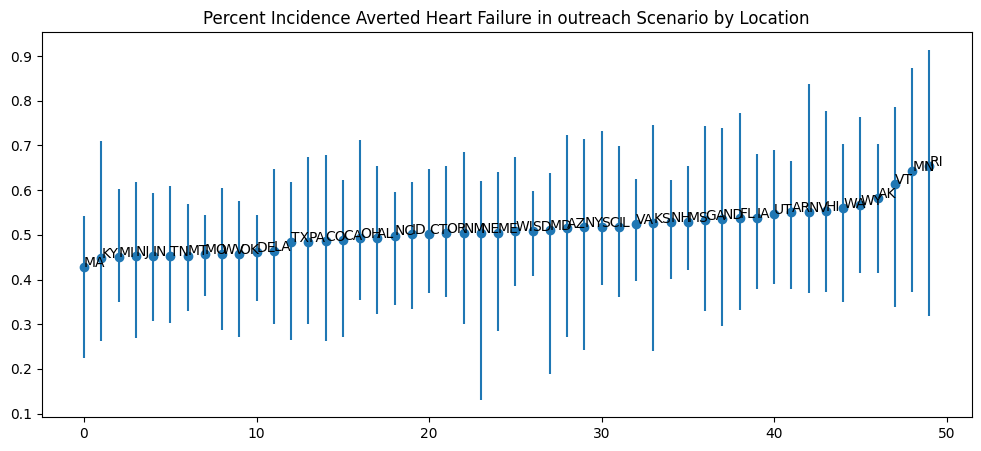

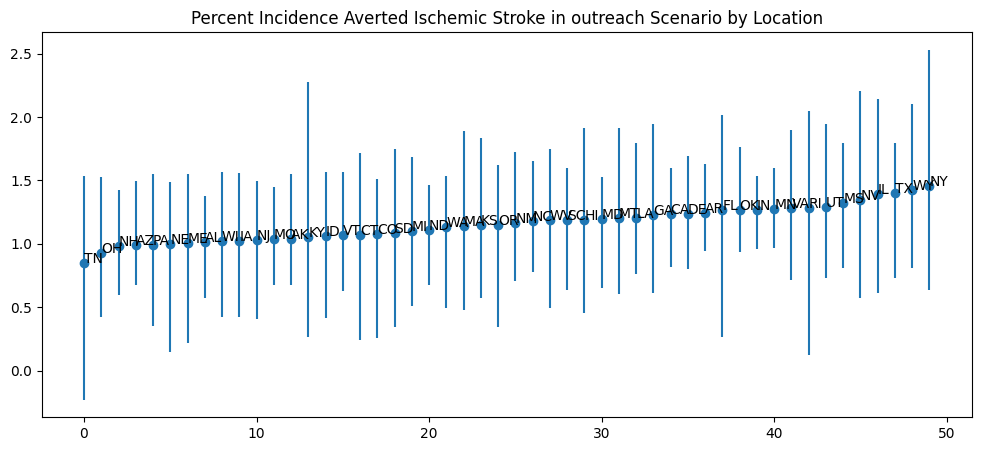

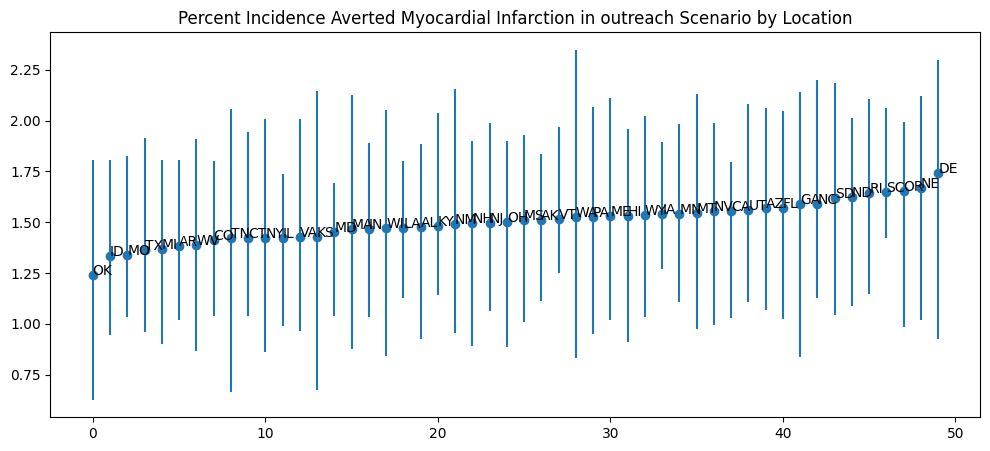

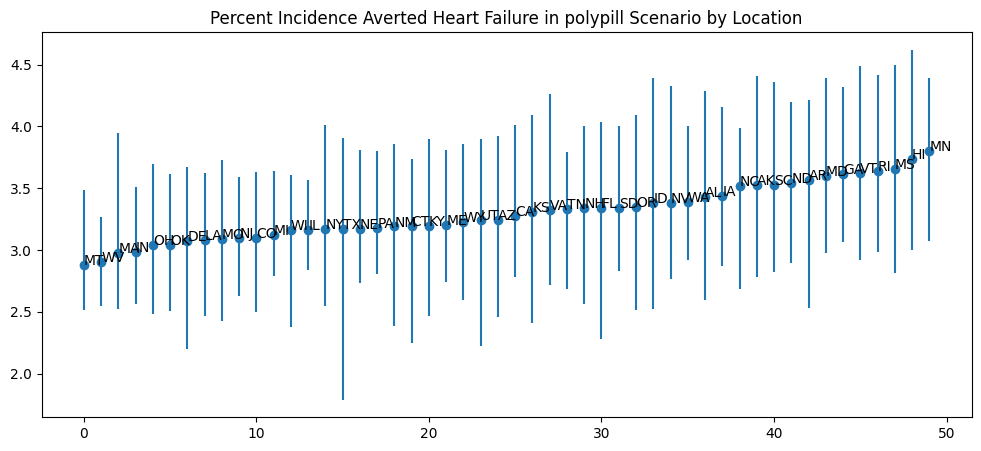

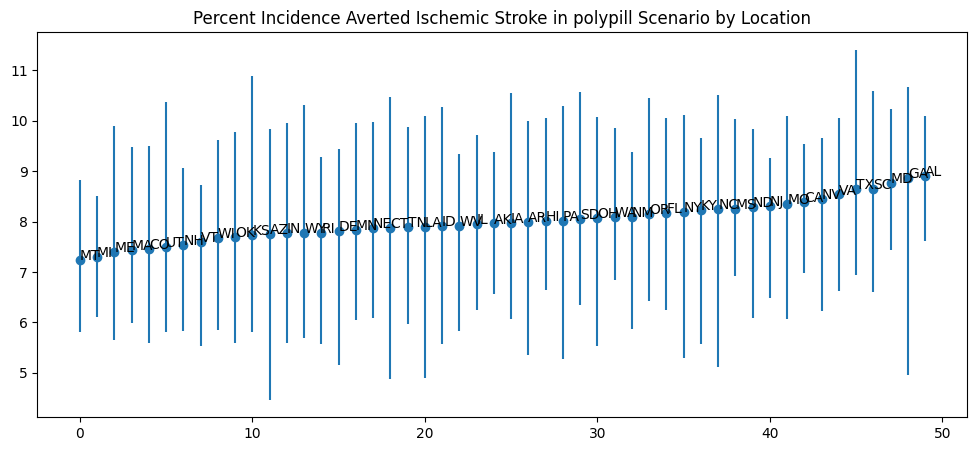

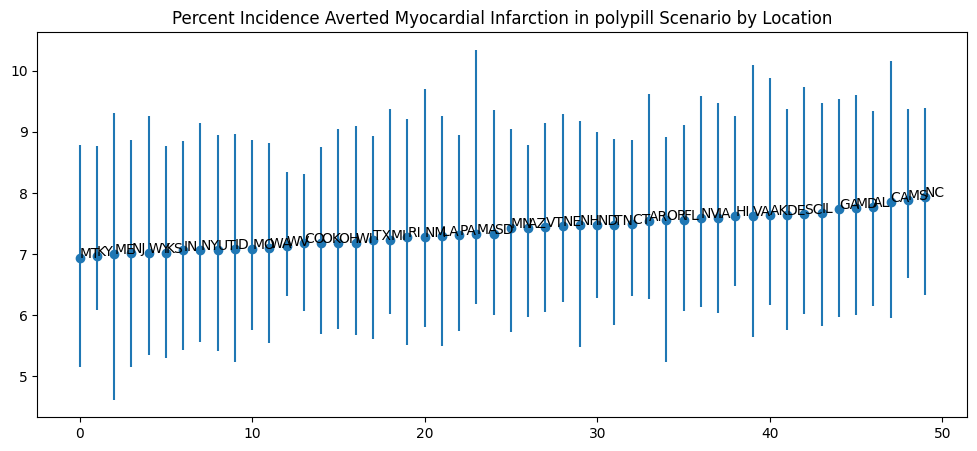

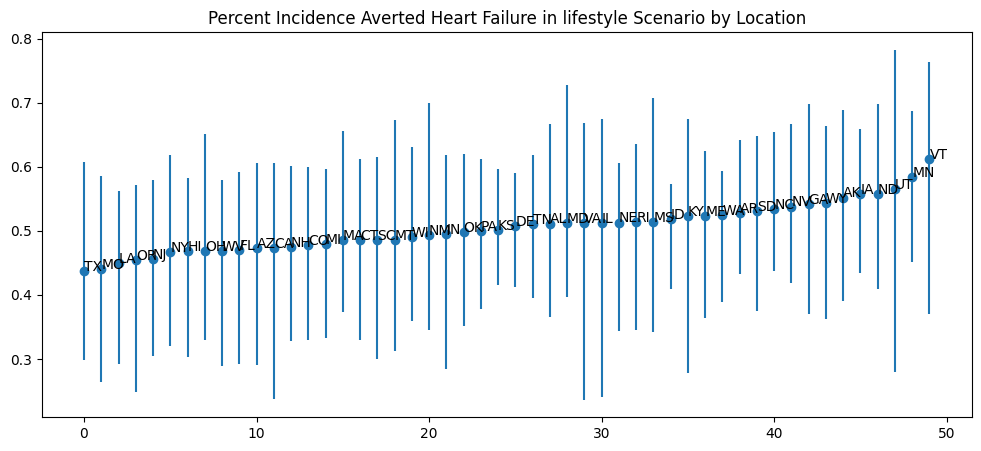

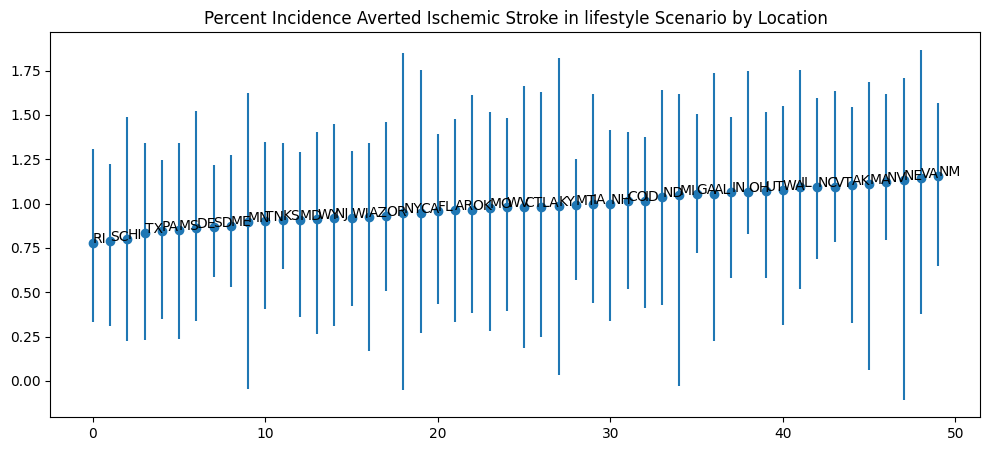

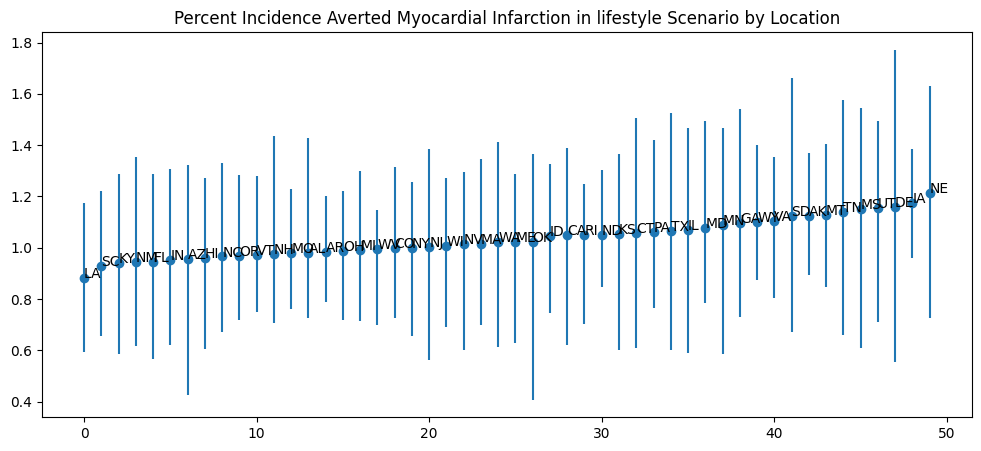

In [30]:
from matplotlib.backends.backend_pdf import PdfPages
with PdfPages('incidence_dot_plot_8_31_23.pdf') as pdf:
    for intervention in ['outreach', 'polypill', 'lifestyle']:
        for trans in tran_state_rate_map.transition_new.unique():
            plt.figure(figsize=(12,5))
            subdata = tran_state_rate_map.loc[(tran_state_rate_map.transition_new == trans)].sort_values([f'averted_percent_mean_{intervention}'])
            y_error = [subdata[f'upper_error_{intervention}'], subdata[f'lower_error_{intervention}']]

            plt.errorbar(range(50), subdata[f'averted_percent_mean_{intervention}'], yerr=y_error, fmt='o') 

            for i in range(50):
                plt.annotate(subdata.abbreviation.iloc[i], (i, subdata[f'averted_percent_mean_{intervention}'].iloc[i] + 0.0002))


            plt.title(f'Percent Incidence Averted {trans} in {intervention} Scenario by Location')
            pdf.savefig(bbox_inches='tight')

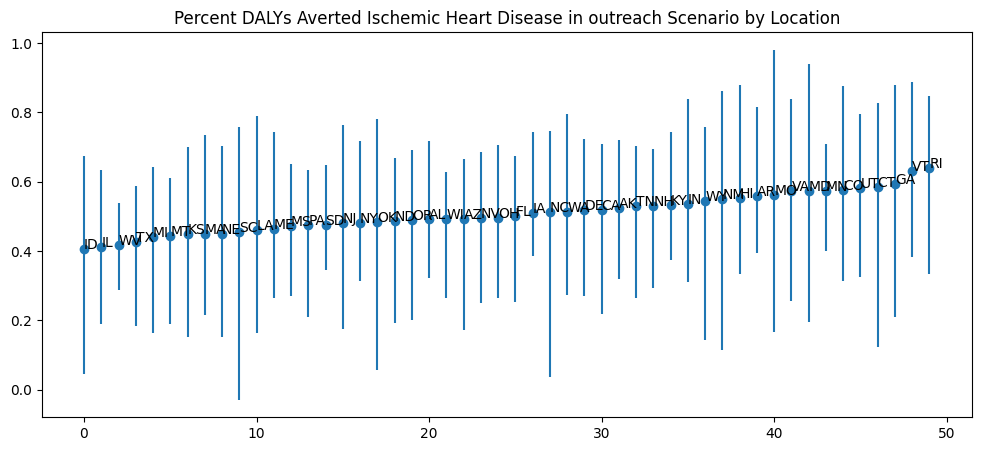

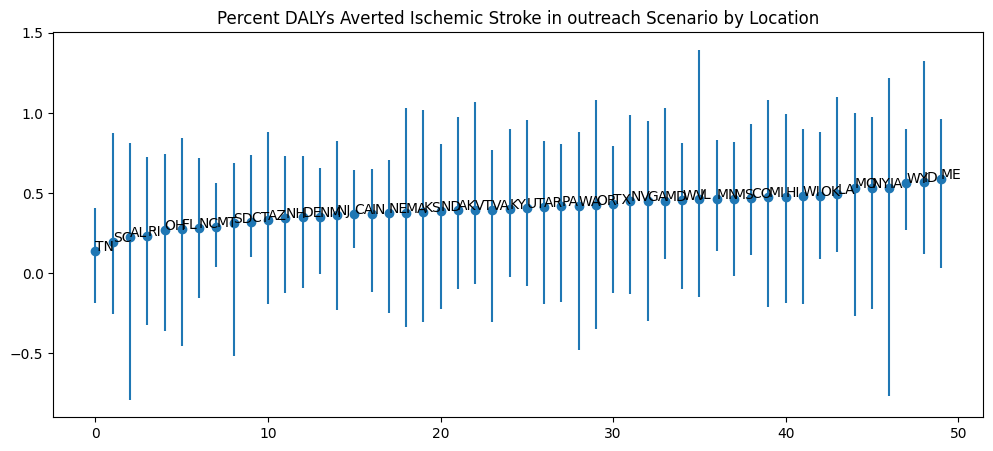

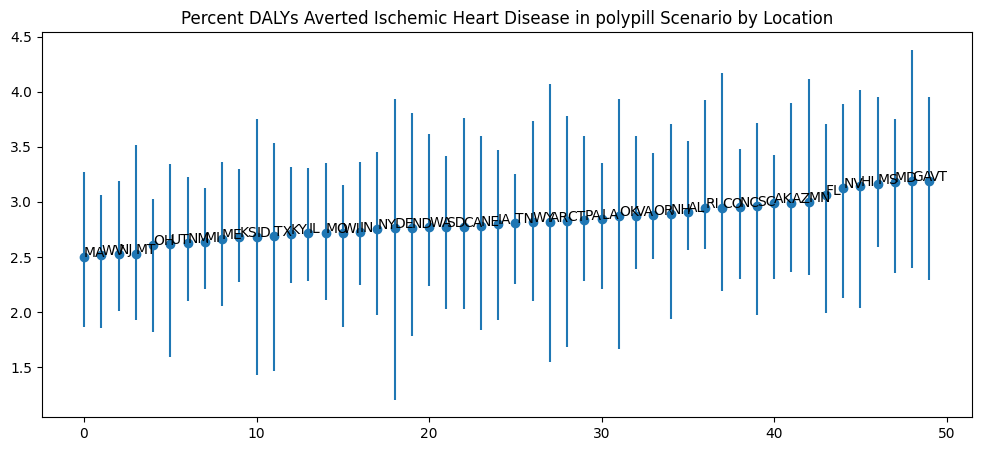

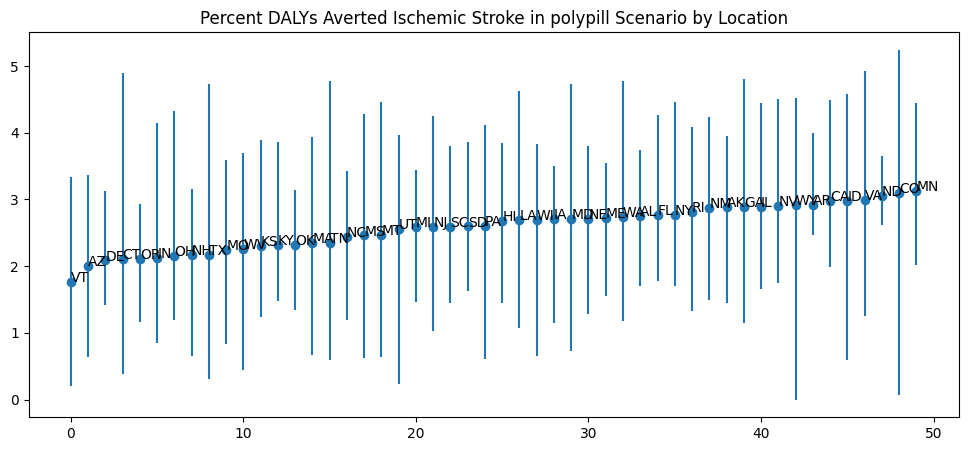

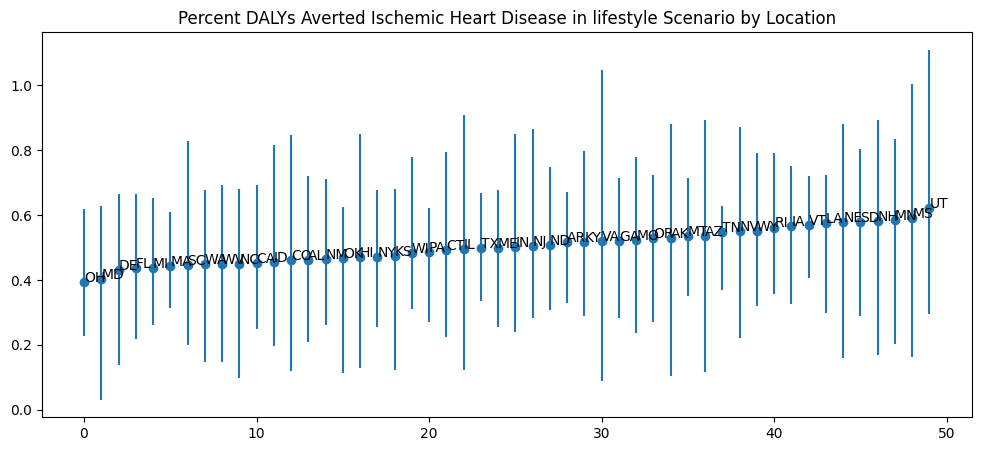

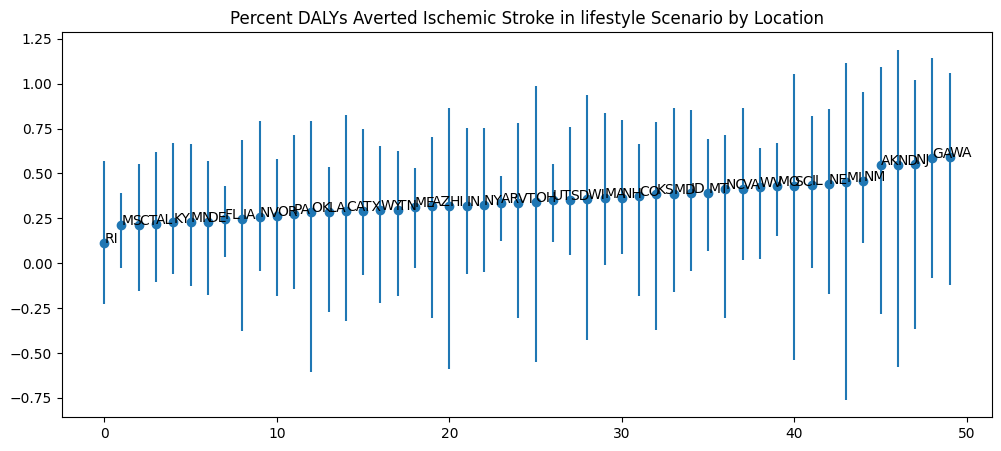

In [32]:
with PdfPages('daly_dot_plot_8_31_23.pdf') as pdf:
    for intervention in ['outreach', 'polypill', 'lifestyle']:
        for trans in daly_state_rate_map.transition_new.unique():
            plt.figure(figsize=(12, 5))
            subdata = daly_state_rate_map.loc[(daly_state_rate_map.transition_new == trans)].sort_values([f'averted_percent_mean_{intervention}'])
            y_error = [subdata[f'upper_error_{intervention}'], subdata[f'lower_error_{intervention}']]

            plt.errorbar(range(50), subdata[f'averted_percent_mean_{intervention}'], yerr=y_error, fmt='o') 

            for i in range(50):
                plt.annotate(subdata.abbreviation.iloc[i], (i, subdata[f'averted_percent_mean_{intervention}'].iloc[i] + 0.0002))

            plt.title(f'Percent DALYs Averted {trans} in {intervention} Scenario by Location')
            pdf.savefig(bbox_inches='tight')


Text(0.5, 1.0, 'Percent DALYs Averted by Scenario, Location')

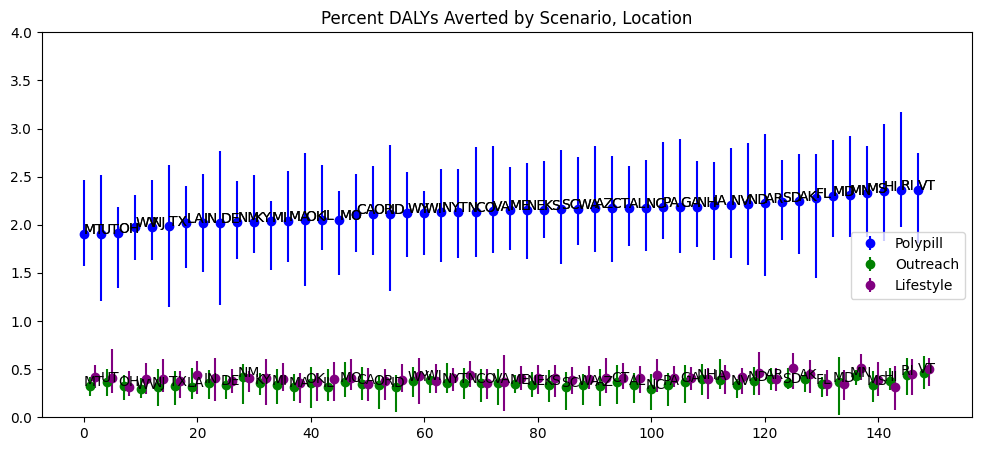

In [70]:
plt.figure(figsize=(12, 5))
subdata = daly_state_rate_map.sort_values([f'averted_percent_mean_polypill'])
y_error_polypill = [subdata[f'upper_error_polypill'], subdata[f'lower_error_polypill']]
y_error_outreach = [subdata[f'upper_error_outreach'], subdata[f'lower_error_outreach']]
y_error_lifestyle = [subdata[f'upper_error_lifestyle'], subdata[f'lower_error_lifestyle']]

plt.errorbar(range(0, 150, 3) , subdata[f'averted_percent_mean_polypill'], yerr=y_error_polypill, fmt='o', color = 'blue', label = 'Polypill') 
plt.errorbar(range(1, 151, 3), subdata[f'averted_percent_mean_outreach'], yerr=y_error_outreach, fmt='o', color = 'green', label = 'Outreach') 
plt.errorbar(range(2, 152, 3), subdata[f'averted_percent_mean_lifestyle'], yerr=y_error_lifestyle, fmt='o', color = 'purple', label = 'Lifestyle') 

for i in range(50):
    plt.annotate(subdata.abbreviation.iloc[i], (i*3+ 0.002, subdata[f'averted_percent_mean_polypill'].iloc[i] ))
    plt.annotate(subdata.abbreviation.iloc[i], (i*3+ 0.002, subdata[f'averted_percent_mean_outreach'].iloc[i] ))
    plt.annotate(subdata.abbreviation.iloc[i], (i*3+ 0.002, subdata[f'averted_percent_mean_polypill'].iloc[i] ))

plt.legend(bbox_to_anchor=(1, 0.5))
plt.ylim(0,4)
plt.xticks()
plt.title(f'Percent DALYs Averted by Scenario, Location')

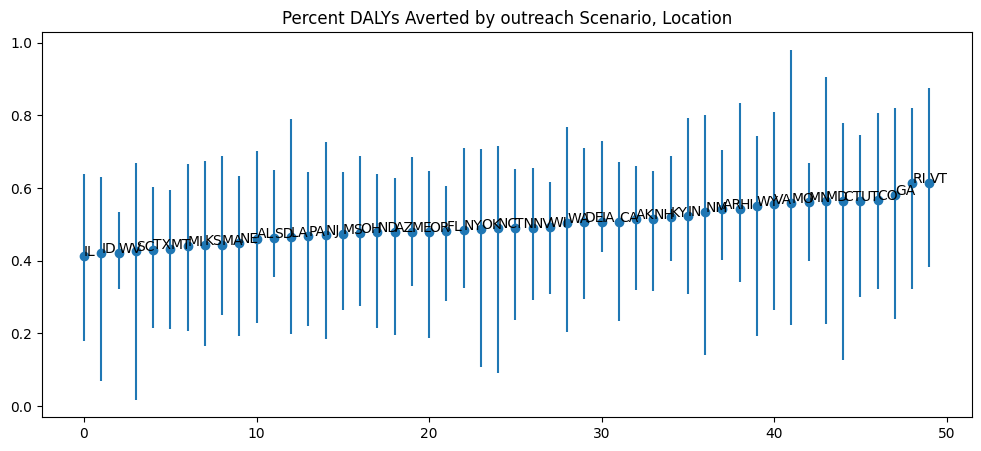

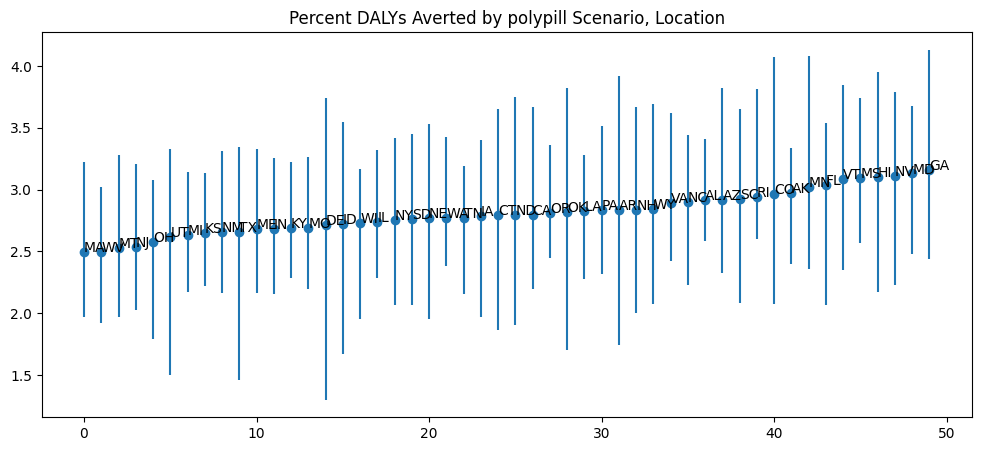

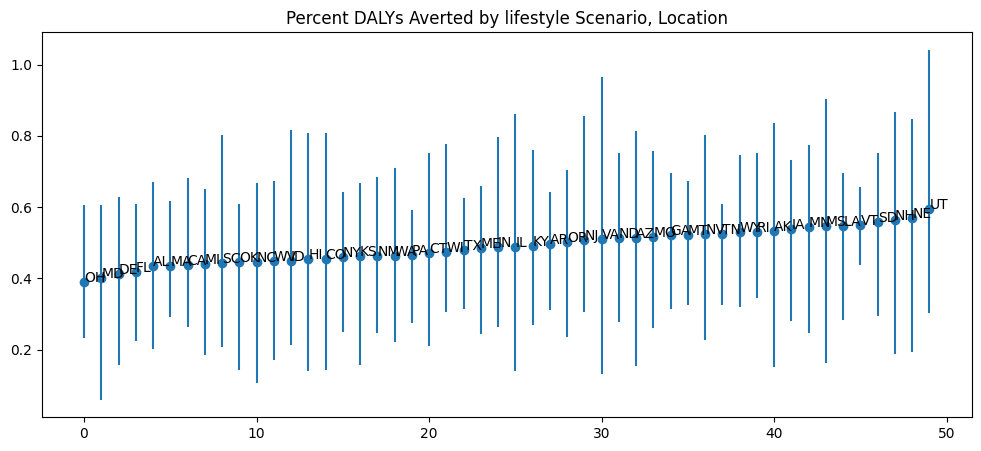

In [39]:
with PdfPages('daly_summary_dot_plot_8_31_23.pdf') as pdf:
    for intervention in ['outreach', 'polypill', 'lifestyle']:

        plt.figure(figsize=(12, 5))
        subdata = daly_state_rate_map.sort_values([f'averted_percent_mean_{intervention}'])
        y_error = [subdata[f'upper_error_{intervention}'], subdata[f'lower_error_{intervention}']]

        plt.errorbar(range(50), subdata[f'averted_percent_mean_{intervention}'], yerr=y_error, fmt='o') 

        for i in range(50):
            plt.annotate(subdata.abbreviation.iloc[i], (i, subdata[f'averted_percent_mean_{intervention}'].iloc[i] + 0.0002))

        plt.title(f'Percent DALYs Averted by {intervention} Scenario, Location')
        pdf.savefig(bbox_inches='tight')
